In [148]:
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/lls/Documents/mlhalos_code/")
import pynbody
import numpy as np
from mlhalos import parameters
from mlhalos import distinct_colours
from mlhalos import window
from scripts.ellipsoidal import predictions as pr
from scripts.EPS import EPS_predictions as EPS_pr
%matplotlib inline

In [25]:
def get_fraction_FPs_vs_overdensity(FPs_ids_density, Fps_ids_den_and_shear, halo_number, initial_overdensity, 
                                    f=None, h=None, ids_all=None, num_overdensities = 11):
    pynbody.analysis.halo.center(f[h[halo_number].properties['mostboundID']], vel=False)
    f.wrap()
    pynbody.analysis.halo.center(h[halo_number], vel=False)

    r_initial = pynbody.analysis.halo.virial_radius(h[halo_number], overden=initial_overdensity)
    overden_initial = initial_overdensity

    r_FPs_den = f[FPs_ids_density]['r']
    r_FPs_den_ell = f[Fps_ids_den_and_shear]['r']
    n_den = len(np.where(r_FPs_den <= r_initial)[0])
    n_den_shear = len(np.where(r_FPs_den_ell <= r_initial)[0])

    # new
    r_all = f[ids_all]['r']
    n_all = len(np.where(r_all <= r_initial)[0])
    
    overden = [overden_initial]
    density_fraction = [n_den/n_all]
    den_shear_fraction = [n_den_shear/n_all]

    den_mean = f.properties["omegaM0"] * pynbody.analysis.cosmology.rho_crit(f, z=0)
    
    for i in range(num_overdensities - 1):
        r_2 = r_initial * 1.8
        
        mass = f[pynbody.filt.Sphere(r_2)]['mass'].sum()
        V = (4/3)*np.pi*(r_2**3)
        density = mass / V
        overden_2 = density/den_mean
        overden.append(overden_2)

        n_all = len(np.where(r_all <= r_2)[0])
        num_FPs_den = len(np.where(r_FPs_den <= r_2)[0])
        density_fraction.append(num_FPs_den/n_all)
        num_FPs_den_ell = len(np.where(r_FPs_den_ell <= r_2)[0])
        den_shear_fraction.append(num_FPs_den_ell/n_all)

        r_initial = r_2
    
    return np.array(overden), np.array(density_fraction), np.array(den_shear_fraction)

In [26]:
def get_num_FPs_vs_overdensity_for_two_cases(Fps_ids_den, Fps_ids_den_shear, ids_tested, halos, num_overdensities=11, f=None, h=None):
    overden_all = np.zeros((len(halos), num_overdensities))
    n_tot_all_den = np.zeros((len(halos), num_overdensities))
    n_tot_all_den_shear = np.zeros((len(halos), num_overdensities))
    halo_mass = np.zeros((len(halos), ))

    for j in range(len(halos)):
        halo_number = halos[j]
        print("Doing halo " + str(halo_number) + " -number " + str(j))
        halo_mass[j] = "%.3g" % h[halo_number]['mass'].sum()
        overden_first = 200

        overden_all[j], n_tot_all_den[j], n_tot_all_den_shear[j] = get_fraction_FPs_vs_overdensity(Fps_ids_den, 
                                                                                                   Fps_ids_den_shear, 
                                                                                                   halo_number, overden_first, 
                                                                                                   f=f, h=h, ids_all=ids_tested, 
                                                                                                   num_overdensities = num_overdensities)
        print("Done halo " + str(j))
    return overden_all, n_tot_all_den, n_tot_all_den_shear, halo_mass

In [145]:
# Bootstrap method to get errorbars

def do_bootstrap_method(n_EPS, n_ellips, bootstrap_number):
    mean_bootstrap_EPS = np.zeros((bootstrap_number, 11))
    median_bootstrap_EPS = np.zeros((bootstrap_number, 11))

    mean_bootstrap_ellipsoidal = np.zeros((bootstrap_number, 11))
    median_bootstrap_ellipsoidal = np.zeros((bootstrap_number, 11))

    for i in range(bootstrap_number):
        random_subset = np.random.choice(len(n_tot_all_EPS), int(len(n_tot_all_EPS)*0.6))
        n_rand_EPS = n_EPS[random_subset]
        n_rand_ellipsoidal = n_ellips[random_subset]

        median_bootstrap_EPS[i] = np.median(n_rand_EPS, axis=0)
        mean_bootstrap_EPS[i] = np.mean(n_rand_EPS, axis=0)

        median_bootstrap_ellipsoidal[i] = np.median(n_rand_ellipsoidal, axis=0)
        mean_bootstrap_ellipsoidal[i] = np.mean(n_rand_ellipsoidal, axis=0)
    
    return mean_bootstrap_EPS, median_bootstrap_EPS, mean_bootstrap_ellipsoidal, median_bootstrap_ellipsoidal

In [5]:
path = "/Users/lls/Documents/CODE/stored_files/shear/classification/"
ids_tested = np.load(path + "tested_ids.npy")

den_f = np.load("/Users/lls/Documents/CODE/stored_files/shear/shear_quantities/features/density_features.npy")
den_f_tested = den_f[ids_tested]
del den_f

In [7]:
ic = parameters.InitialConditionsParameters(path="/Users/lls/Documents/CODE/")
w = window.WindowParameters(initial_parameters=ic, num_filtering_scales=50)

f = ic.final_snapshot
f.physical_units("kpc")
h = ic.halo

In [8]:
ellipsoidal_label = pr.ellipsoidal_collapse_predicted_label(den_f_tested[:, :-1], initial_parameters=ic, 
                                                            window_parameters=w, beta=0.485, gamma=0.615, a=0.75)
true_label = den_f_tested[:, -1]

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/pynbody/analysis/hmf.py:95: RuntimeWarning: Using the default power-spectrum spectrum which assumes ns=0.96 and WMAP7+H0+BAO transfer function.
  "Using the default power-spectrum spectrum which assumes ns=0.96 and WMAP7+H0+BAO transfer function.", RuntimeWarning)
/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'sigma8'=8.29e-01
  name, value), RuntimeWarning)
/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/pynbody/analysis/hmf.py:168: RuntimeWarning: Power spectrum does not extend to low enough k; using power-law extrapolation (this is likely to be fine)
  "Power spectrum does not extend to low enough k; using power-law extrapolation (this is likely to be fine)", RuntimeWarning)


NameError: name 'testing_density_features' is not defined

In [9]:
true_label = den_f_tested[:, -1]

In [10]:
pr.get_fpr_tpr_ellipsoidal_prediction(ellipsoidal_label, true_label)

(0.17028380634390652, 0.7282897714360641)

In [35]:
import importlib
importlib.reload(pr)

<module 'scripts.ellipsoidal.predictions' from '/Users/lls/Documents/mlhalos_code/scripts/ellipsoidal/predictions.py'>

In [11]:
# Ellipsoidal false positives

fpr_indices_ellipsoidal, tpr_indices_ellipsoidal = pr.get_fpr_tpr_indices(ellipsoidal_label, true_label)
Fps_ids_ellipsoidal = ids_tested[fpr_indices_ellipsoidal]

In [12]:
# Extended Press-Schechter false positives

EPS_predicted_label = EPS_pr.EPS_label(den_f_tested[:, :-1])
fpr_indices_EPS, tpr_indices_EPS = pr.get_fpr_tpr_indices(EPS_predicted_label, true_label)

IndexError: too many indices for array

In [15]:
fpr_indices_EPS, tpr_indices_EPS = pr.get_fpr_tpr_indices(EPS_predicted_label, true_label)
Fps_ids_EPS = ids_tested[fpr_indices_EPS]

In [16]:
pr.get_fpr_tpr_ellipsoidal_prediction(EPS_predicted_label, true_label)

(0.13391190563075103, 0.67887172680147767)

In [17]:
high_mass = np.arange(0, 7)
mid_mass = np.arange(7, 78)
small_mass = np.random.choice(np.arange(78, 400), 100)

In [18]:
c = distinct_colours.get_distinct(2)

# High mass

In [34]:
halos = high_mass
num_overdensities = 11

overden_all = np.zeros((len(halos), num_overdensities))
n_tot_all_EPS = np.zeros((len(halos), num_overdensities))
n_tot_all_ellipsoidal = np.zeros((len(halos), num_overdensities))
halo_mass = np.zeros((len(halos), ))

for j in range(len(halos)):
    halo_number = halos[j]
    print("Doing halo " + str(halo_number) + " -number " + str(j))
    halo_mass[j] = "%.3g" % h[halo_number]['mass'].sum()
    overden_first = 200

    overden_all[j], n_tot_all_EPS[j], n_tot_all_ellipsoidal[j] = get_fraction_FPs_vs_overdensity(Fps_ids_EPS, 
                                                                                               Fps_ids_ellipsoidal, 
                                                                                               halo_number, overden_first, 
                                                                                               f=f, h=h, ids_all=ids_tested, 
                                                                                               num_overdensities = num_overdensities)
    print("Done halo " + str(j))

Doing halo 0 -number 0
Done halo 0
Doing halo 1 -number 1
Done halo 1
Doing halo 2 -number 2
Done halo 2
Doing halo 3 -number 3
Done halo 3
Doing halo 4 -number 4
Done halo 4
Doing halo 5 -number 5
Done halo 5
Doing halo 6 -number 6
Done halo 6


In [122]:
num_bootstrap = 10000000

mean_bootstrap_EPS, median_bootstrap_EPS, mean_bootstrap_ellipsoidal, median_bootstrap_ellipsoidal = do_bootstrap_method(n_tot_all_EPS, n_tot_all_ellipsoidal, num_bootstrap)

estimate_mean_EPS = np.sum(mean_bootstrap_EPS, axis=0)/num_bootstrap
estimate_std_mean_EPS = np.std(mean_bootstrap_EPS, axis=0)

estimate_median_EPS = np.sum(median_bootstrap_EPS, axis=0)/num_bootstrap
estimate_std_median_EPS = np.std(median_bootstrap_EPS, axis=0)

estimate_mean_ellipsoidal = np.sum(mean_bootstrap_ellipsoidal, axis=0)/num_bootstrap
estimate_std_mean_ellipsoidal = np.std(mean_bootstrap_ellipsoidal, axis=0)

estimate_median_ellipsoidal = np.sum(median_bootstrap_ellipsoidal, axis=0)/num_bootstrap
estimate_std_median_ellipsoidal = np.std(median_bootstrap_ellipsoidal, axis=0)

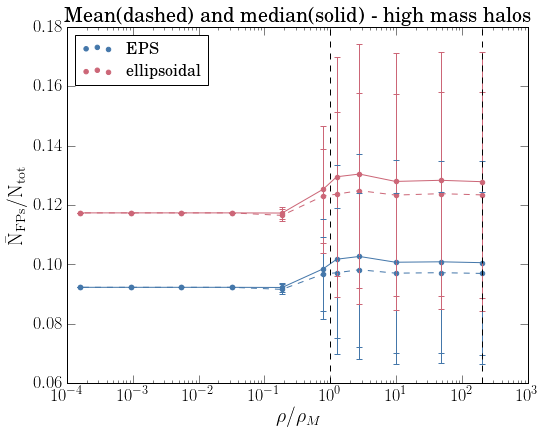

In [130]:
# MEAN AND MEDIAN WITH BOOTSTRAP METHOD

ind_i = np.argsort(overden_all[0])[::-1]

plt.figure(figsize=(8,6))

plt.scatter(overden_all[0, ind_i], estimate_mean_EPS[ind_i], color=c[0], s=20, label="EPS")
plt.errorbar(overden_all[0, ind_i], estimate_mean_EPS[ind_i], yerr=estimate_std_mean_EPS[ind_i], color=c[0],ls="--")

plt.errorbar(overden_all[0, ind_i], estimate_median_EPS[ind_i],yerr=estimate_std_median_EPS[ind_i], color=c[0])
plt.scatter(overden_all[0, ind_i], estimate_median_EPS[ind_i], color=c[0], s=20)

plt.scatter(overden_all[0, ind_i], estimate_mean_ellipsoidal[ind_i], color=c[1], s=20,label="ellipsoidal")
plt.errorbar(overden_all[0, ind_i], estimate_mean_ellipsoidal[ind_i], yerr=estimate_std_mean_ellipsoidal[ind_i], color=c[1],ls="--")

plt.errorbar(overden_all[0, ind_i], estimate_median_ellipsoidal[ind_i], yerr=estimate_std_median_ellipsoidal[ind_i],color=c[1])
plt.scatter(overden_all[0, ind_i], estimate_median_ellipsoidal[ind_i], color=c[1], s=20)

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
# plt.ylabel(r"$\mathrm{N_{FPs}} / \sum{\mathrm{N_{FPs}}}$")
# plt.xscale("symlog")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) - high mass halos")

plt.savefig("/Users/lls/Desktop/EPS_vs_ellipsoidal_high_mass_bootstrap.pdf")

Distributions are bimodal - mean is not a good measure!


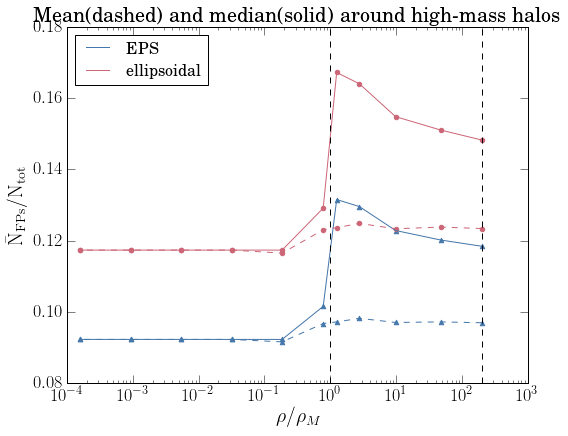

In [67]:
# median curve
median_EPS = np.median(n_tot_all_EPS, axis=0)
median_ellipsoidal = np.median(n_tot_all_ellipsoidal, axis=0)

mean_EPS = np.mean(n_tot_all_EPS, axis=0)
mean_ellipsoidal = np.mean(n_tot_all_ellipsoidal, axis=0)

ind_i = np.argsort(overden_all[0])[::-1]

plt.figure(figsize=(8,6))
plt.plot(overden_all[0, ind_i], median_EPS[ind_i], color=c[0], ls="-", label="EPS")
plt.scatter(overden_all[0, ind_i], median_EPS[ind_i], color=c[0], s=20, marker="^")
plt.plot(overden_all[0, ind_i], mean_EPS[ind_i], color=c[0], ls="--")
plt.scatter(overden_all[0, ind_i], mean_EPS[ind_i], color=c[0], s=20, marker="^")

plt.plot(overden_all[0, ind_i], median_ellipsoidal[ind_i], color=c[1], label="ellipsoidal")
plt.scatter(overden_all[0, ind_i], median_ellipsoidal[ind_i], color=c[1], s=20)
plt.plot(overden_all[0, ind_i], mean_ellipsoidal[ind_i], color=c[1], ls="--")
plt.scatter(overden_all[0, ind_i], mean_ellipsoidal[ind_i], color=c[1], s=20)

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
# plt.ylabel(r"$\mathrm{N_{FPs}} / \sum{\mathrm{N_{FPs}}}$")
# plt.xscale("symlog")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) around high-mass halos")

print("Distributions are bimodal - mean is not a good measure!")

# Mid mass

In [38]:
halos = mid_mass
num_overdensities = 11

overden_all_mid = np.zeros((len(halos), num_overdensities))
n_tot_all_EPS_mid = np.zeros((len(halos), num_overdensities))
n_tot_all_ellipsoidal_mid = np.zeros((len(halos), num_overdensities))
halo_mass_mid = np.zeros((len(halos), ))

for j in range(len(halos)):
    halo_number = halos[j]
    print("Doing halo " + str(halo_number) + " -number " + str(j))
    halo_mass_mid[j] = "%.3g" % h[halo_number]['mass'].sum()
    overden_first = 200

    overden_all_mid[j], n_tot_all_EPS_mid[j], n_tot_all_ellipsoidal_mid[j] = get_fraction_FPs_vs_overdensity(Fps_ids_EPS, 
                                                                                               Fps_ids_ellipsoidal, 
                                                                                               halo_number, overden_first, 
                                                                                               f=f, h=h, ids_all=ids_tested, 
                                                                                               num_overdensities = num_overdensities)
    print("Done halo " + str(j))

Doing halo 7 -number 0
Done halo 0
Doing halo 8 -number 1
Done halo 1
Doing halo 9 -number 2
Done halo 2
Doing halo 10 -number 3
Done halo 3
Doing halo 11 -number 4
Done halo 4
Doing halo 12 -number 5
Done halo 5
Doing halo 13 -number 6
Done halo 6
Doing halo 14 -number 7
Done halo 7
Doing halo 15 -number 8
Done halo 8
Doing halo 16 -number 9
Done halo 9
Doing halo 17 -number 10
Done halo 10
Doing halo 18 -number 11
Done halo 11
Doing halo 19 -number 12
Done halo 12
Doing halo 20 -number 13
Done halo 13
Doing halo 21 -number 14
Done halo 14
Doing halo 22 -number 15
Done halo 15
Doing halo 23 -number 16
Done halo 16
Doing halo 24 -number 17
Done halo 17
Doing halo 25 -number 18
Done halo 18
Doing halo 26 -number 19
Done halo 19
Doing halo 27 -number 20
Done halo 20
Doing halo 28 -number 21
Done halo 21
Doing halo 29 -number 22
Done halo 22
Doing halo 30 -number 23
Done halo 23
Doing halo 31 -number 24
Done halo 24
Doing halo 32 -number 25
Done halo 25
Doing halo 33 -number 26
Done halo 

In [134]:
num_bootstrap = 10000

mid_mean_bootstrap_EPS, mid_median_bootstrap_EPS, mid_mean_bootstrap_ellipsoidal, mid_median_bootstrap_ellipsoidal = do_bootstrap_method(n_tot_all_EPS_mid, n_tot_all_ellipsoidal_mid, num_bootstrap)

mid_estimate_mean_EPS = np.sum(mid_mean_bootstrap_EPS, axis=0)/num_bootstrap
mid_estimate_std_mean_EPS = np.std(mid_mean_bootstrap_EPS, axis=0)

mid_estimate_median_EPS = np.sum(mid_median_bootstrap_EPS, axis=0)/num_bootstrap
mid_estimate_std_median_EPS = np.std(mid_median_bootstrap_EPS, axis=0)


mid_estimate_mean_ellips = np.sum(mid_mean_bootstrap_ellipsoidal, axis=0)/num_bootstrap
mid_estimate_std_mean_ellips = np.std(mid_mean_bootstrap_ellipsoidal, axis=0)

mid_estimate_median_ellips = np.sum(mid_median_bootstrap_ellipsoidal, axis=0)/num_bootstrap
mid_estimate_std_median_ellips = np.std(mid_median_bootstrap_ellipsoidal, axis=0)

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


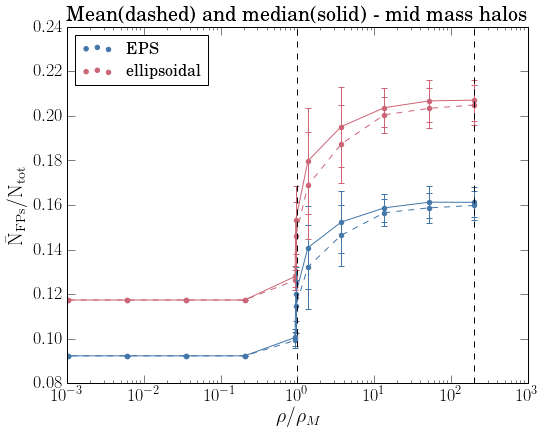

In [136]:
# RESULT AFTER BOOTSTRAP METHOD

mid_ind_i = np.argsort(overden_all_mid[0])[::-1]

plt.figure(figsize=(8,6))

plt.errorbar(overden_all_mid[0, mid_ind_i], mid_estimate_mean_EPS[mid_ind_i], color=c[0], 
             yerr=mid_estimate_std_mean_EPS[mid_ind_i], ls="--")
plt.scatter(overden_all_mid[0, mid_ind_i], mid_estimate_mean_EPS[mid_ind_i], color=c[0], label="EPS")

plt.errorbar(overden_all_mid[0, mid_ind_i], mid_estimate_median_EPS[mid_ind_i], 
             yerr=mid_estimate_std_median_EPS[mid_ind_i], color=c[0])
plt.scatter(overden_all_mid[0, mid_ind_i], mid_estimate_median_EPS[mid_ind_i], color=c[0])

plt.errorbar(overden_all_mid[0, mid_ind_i], mid_estimate_mean_ellips[mid_ind_i], color=c[1], 
             yerr=mid_estimate_std_mean_ellips[mid_ind_i], ls="--")
plt.scatter(overden_all_mid[0, mid_ind_i], mid_estimate_mean_ellips[mid_ind_i], color=c[1], label="ellipsoidal")

plt.errorbar(overden_all_mid[0, mid_ind_i], mid_estimate_median_ellips[mid_ind_i], 
             yerr=mid_estimate_std_median_ellips[mid_ind_i], color=c[1])
plt.scatter(overden_all_mid[0, mid_ind_i], mid_estimate_median_ellips[mid_ind_i], color=c[1])

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) - mid mass halos")

plt.savefig("/Users/lls/Desktop/EPS_vs_ellipsoidal_mid_mass_bootstrap.pdf")

Distributions are bimodal - mean is not a good measure!


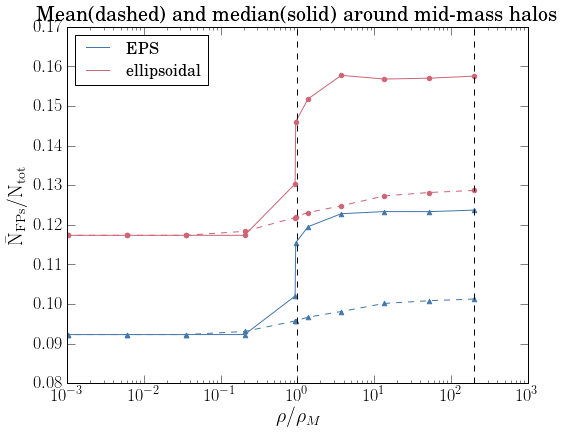

In [68]:
# median + mean curve

median_EPS_mid = np.median(n_tot_all_EPS_mid, axis=0)
median_ellipsoidal_mid = np.median(n_tot_all_ellipsoidal_mid, axis=0)

mean_EPS_mid = np.mean(n_tot_all_EPS_mid, axis=0)
mean_ellipsoidal_mid = np.mean(n_tot_all_ellipsoidal_mid, axis=0)

ind_i = np.argsort(overden_all_mid[0])[::-1]

plt.figure(figsize=(8,6))
plt.plot(overden_all_mid[0, ind_i], median_EPS_mid[ind_i], color=c[0], ls="-", label="EPS")
plt.scatter(overden_all_mid[0, ind_i], median_EPS_mid[ind_i], color=c[0], s=20, marker="^")
plt.plot(overden_all_mid[0, ind_i], mean_EPS_mid[ind_i], color=c[0], ls="--")
plt.scatter(overden_all_mid[0, ind_i], mean_EPS_mid[ind_i], color=c[0], s=20, marker="^")

plt.plot(overden_all_mid[0, ind_i], median_ellipsoidal_mid[ind_i], color=c[1], label="ellipsoidal")
plt.scatter(overden_all_mid[0, ind_i], median_ellipsoidal_mid[ind_i], color=c[1], s=20)
plt.plot(overden_all_mid[0, ind_i], mean_ellipsoidal_mid[ind_i], color=c[1], ls="--")
plt.scatter(overden_all_mid[0, ind_i], mean_ellipsoidal_mid[ind_i], color=c[1], s=20)

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
# plt.ylabel(r"$\mathrm{N_{FPs}} / \sum{\mathrm{N_{FPs}}}$")
# plt.xscale("symlog")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) around mid-mass halos")

print("Distributions are bimodal - mean is not a good measure!")

0.12278521508022443

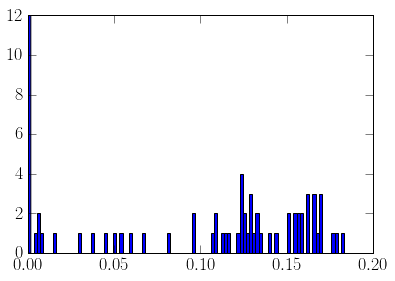

In [58]:
plt.hist(n_tot_all_EPS_mid[:,3], bins=100)
np.median(n_tot_all_EPS_mid[:,3])

# Small mass

In [40]:
halos = small_mass
num_overdensities = 11

overden_all_small = np.zeros((len(halos), num_overdensities))
n_tot_all_EPS_small = np.zeros((len(halos), num_overdensities))
n_tot_all_ellipsoidal_small = np.zeros((len(halos), num_overdensities))
halo_mass_small = np.zeros((len(halos), ))

for j in range(len(halos)):
    halo_number = halos[j]
    print("Doing halo " + str(halo_number) + " -number " + str(j))
    halo_mass_small[j] = "%.3g" % h[halo_number]['mass'].sum()
    overden_first = 200

    overden_all_small[j], n_tot_all_EPS_small[j], n_tot_all_ellipsoidal_small[j] = get_fraction_FPs_vs_overdensity(Fps_ids_EPS, 
                                                                                               Fps_ids_ellipsoidal, 
                                                                                               halo_number, overden_first, 
                                                                                               f=f, h=h, ids_all=ids_tested, 
                                                                                               num_overdensities = num_overdensities)
    print("Done halo " + str(j))

Doing halo 210 -number 0
Done halo 0
Doing halo 380 -number 1
Done halo 1
Doing halo 193 -number 2
Done halo 2
Doing halo 160 -number 3
Done halo 3
Doing halo 171 -number 4
Done halo 4
Doing halo 223 -number 5
Done halo 5
Doing halo 379 -number 6
Done halo 6
Doing halo 370 -number 7
Done halo 7
Doing halo 327 -number 8
Done halo 8
Doing halo 144 -number 9
Done halo 9
Doing halo 127 -number 10
Done halo 10
Doing halo 372 -number 11
Done halo 11
Doing halo 255 -number 12
Done halo 12
Doing halo 102 -number 13
Done halo 13
Doing halo 293 -number 14
Done halo 14
Doing halo 345 -number 15
Done halo 15
Doing halo 106 -number 16
Done halo 16
Doing halo 324 -number 17
Done halo 17
Doing halo 216 -number 18
Done halo 18
Doing halo 84 -number 19
Done halo 19
Doing halo 210 -number 20
Done halo 20
Doing halo 387 -number 21
Done halo 21
Doing halo 364 -number 22
Done halo 22
Doing halo 346 -number 23
Done halo 23
Doing halo 260 -number 24
Done halo 24
Doing halo 134 -number 25
Done halo 25
Doing h

Distributions are bimodal - mean is not a good measure!


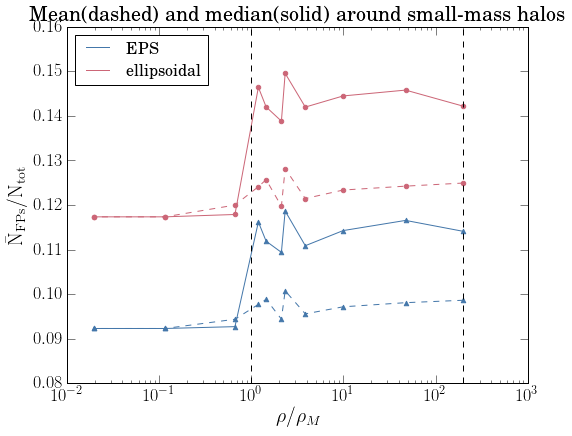

In [69]:
# median + mean curve
median_EPS_small = np.median(n_tot_all_EPS_small, axis=0)
median_ellipsoidal_small = np.median(n_tot_all_ellipsoidal_small, axis=0)

mean_EPS_small = np.mean(n_tot_all_EPS_small, axis=0)
mean_ellipsoidal_small = np.mean(n_tot_all_ellipsoidal_small, axis=0)

ind_i = np.argsort(overden_all_small[0])[::-1]

plt.figure(figsize=(8,6))
plt.plot(overden_all_small[0, ind_i], median_EPS_small[ind_i], color=c[0], ls="-", label="EPS")
plt.scatter(overden_all_small[0, ind_i], median_EPS_small[ind_i], color=c[0], s=20, marker="^")
plt.plot(overden_all_small[0, ind_i], mean_EPS_small[ind_i], color=c[0], ls="--")
plt.scatter(overden_all_small[0, ind_i], mean_EPS_small[ind_i], color=c[0], s=20, marker="^")

plt.plot(overden_all_small[0, ind_i], median_ellipsoidal_small[ind_i], color=c[1], label="ellipsoidal")
plt.scatter(overden_all_small[0, ind_i], median_ellipsoidal_small[ind_i], color=c[1], s=20)
plt.plot(overden_all_small[0, ind_i], mean_ellipsoidal_small[ind_i], color=c[1], ls="--")
plt.scatter(overden_all_small[0, ind_i], mean_ellipsoidal_small[ind_i], color=c[1], s=20)

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
# plt.ylabel(r"$\mathrm{N_{FPs}} / \sum{\mathrm{N_{FPs}}}$")
# plt.xscale("symlog")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) around small-mass halos")

print("Distributions are bimodal - mean is not a good measure!")

In [146]:
num_bootstrap = 100000

small_mean_bootstrap_EPS, small_median_bootstrap_EPS, small_mean_bootstrap_ellipsoidal, small_median_bootstrap_ellipsoidal = do_bootstrap_method(n_tot_all_EPS_small, n_tot_all_ellipsoidal_small, num_bootstrap)

small_estimate_mean_EPS = np.sum(small_mean_bootstrap_EPS, axis=0)/num_bootstrap
small_estimate_std_mean_EPS = np.std(small_mean_bootstrap_EPS, axis=0)

small_estimate_median_EPS = np.sum(small_median_bootstrap_EPS, axis=0)/num_bootstrap
small_estimate_std_median_EPS = np.std(small_median_bootstrap_EPS, axis=0)


small_estimate_mean_ellips = np.sum(small_mean_bootstrap_ellipsoidal, axis=0)/num_bootstrap
small_estimate_std_mean_ellips = np.std(small_mean_bootstrap_ellipsoidal, axis=0)

small_estimate_median_ellips = np.sum(small_median_bootstrap_ellipsoidal, axis=0)/num_bootstrap
small_estimate_std_median_ellips = np.std(small_median_bootstrap_ellipsoidal, axis=0)

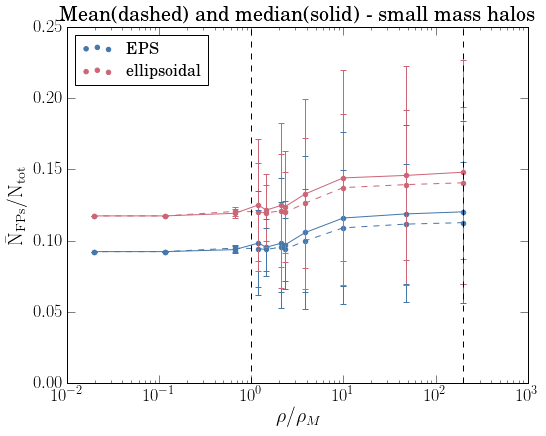

In [147]:
# RESULT AFTER BOOTSTRAP METHOD

small_ind_i = np.argsort(overden_all_small[0])[::-1]

plt.figure(figsize=(8,6))

plt.errorbar(overden_all_small[0, small_ind_i], small_estimate_mean_EPS[small_ind_i], color=c[0], 
             yerr=small_estimate_std_mean_EPS[small_ind_i], ls="--")
plt.scatter(overden_all_small[0, small_ind_i], small_estimate_mean_EPS[small_ind_i], color=c[0], label="EPS")

plt.errorbar(overden_all_small[0, small_ind_i],small_estimate_median_EPS[small_ind_i], 
             yerr=small_estimate_std_median_EPS[small_ind_i], color=c[0])
plt.scatter(overden_all_small[0, small_ind_i], small_estimate_median_EPS[small_ind_i], color=c[0])

plt.errorbar(overden_all_small[0, small_ind_i], small_estimate_mean_ellips[small_ind_i], color=c[1], 
             yerr=small_estimate_std_mean_ellips[small_ind_i], ls="--")
plt.scatter(overden_all_small[0, small_ind_i], small_estimate_mean_ellips[small_ind_i], color=c[1], label="ellipsoidal")

plt.errorbar(overden_all_small[0, small_ind_i], small_estimate_median_ellips[small_ind_i], 
             yerr=small_estimate_std_median_ellips[small_ind_i], color=c[1])
plt.scatter(overden_all_small[0, small_ind_i], small_estimate_median_ellips[small_ind_i], color=c[1])

plt.legend(loc="best", fontsize=16)
plt.xlabel(r"$\rho / \rho_M$")
plt.ylabel(r"$\mathrm{\bar{N}_{FPs}} / \mathrm{N_{tot}}$")
plt.xscale("log")

plt.axvline(x=200, ls="--", color="k")
plt.axvline(x=1, ls="--", color="k")
plt.title("Mean(dashed) and median(solid) - small mass halos")

plt.savefig("/Users/lls/Desktop/EPS_vs_ellipsoidal_small_mass_bootstrap.pdf")